<a href="https://colab.research.google.com/github/hayashiman/sports_entertaiment_topic_analysis/blob/sub/travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!pip install gensim
!pip install wordcloud 
!pip install pyLDAvis

In [0]:
import glob
import numpy as np
import random
from tqdm import tqdm
import math
import MeCab
import urllib
import gensim
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud
from PIL import Image
import matplotlib
import matplotlib.pylab as plt

from gensim import corpora, models, matutils
import pickle

np.random.seed(0)
FONT = "/content/drive/My Drive/ernie/travel_data/font/ipag.ttf"

In [0]:
# paths to textss
text_paths = glob.glob('/content/drive/My Drive/ernie/travel_data/new_new_text/**/*.txt')

# define stop words
req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')
with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')
while '' in stopwords:
    stopwords.remove('')

In [0]:
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):

    node = mecab.parseToNode(text)
    words = []

    while node:

        features = node.feature.split(',')
        surface = features[6]

        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue

        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')


        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)

        node = node.next

    return words

In [0]:
import re
#無関係なワード削除
def format_text(text):

    text=re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", text)
    text=re.sub('スポット', "", text)
    text=re.sub(r'[!-~]', "", text)#半角記号,数字,英字
    text=re.sub(r'[︰-＠]', "", text)#全角記号
    #text=re.sub('\n', " ", text)#改行文字

    return text

In [0]:
# make dictionary and corpus
mecab = MeCab.Tagger('-Owakati')
titles = []
texts = []
#text文書の個数
count = 0

for text_path in text_paths:
    #print(text_path)

    text = open(text_path, 'r').read()
    text = text.split('\n')
    #title = text[2]
    text = ' '.join(text[3:])
    #print(text)
    format_words = format_text(text)
    words = analyzer(format_words, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
    #print(words)
    texts.append(words)
    #print(texts)
    count += 1

dictionary = corpora.Dictionary.load_from_text('/content/drive/My Drive/ernie/travel_data/data/dic1.txt')
"""
gensim.corpora.Dictionary(texts)
print(dictionary.token2id)
dictionary.filter_extremes(no_below=3, no_above=0.5)
print(dictionary)
"""
corpus = [dictionary.doc2bow(t) for t in texts]
print(corpus)

In [0]:
#現状の辞書をいったん保存
#dictionary.save_as_text('/content/drive/My Drive/ernie/travel_data/data/dic2.txt')
#dictionary = corpora.Dictionary.load_from_text('/content/drive/My Drive/ernie/travel_data/data/dic2.txt')

In [0]:
#bowではなく、tfidfを試す
"""
import os
import gc
import logging
import pickle
from smart_open import open

# tfidf
tfidf = gensim.models.TfidfModel(corpus)
tfidf.save('model.tfidf')

# make corpus_tfidf
corpus_tfidf = tfidf[corpus]

# save corpus_tfidf
with open("corpus_tfidf.pkl",'wb') as f:
    pickle.dump(corpus_tfidf,f)

print(corpus_tfidf)
"""

In [0]:
# KL divergenceの定義と描画
def calc_topic_distances(m, topic):
    import numpy as np

    def kldiv(p, q):
        distance = np.sum(p * np.log(p / q))
        return distance

    # get probability of each words
    # https://github.com/piskvorky/gensim/blob/develop/gensim/models/ldamodel.py#L733

    t = m.state.get_lambda()
    for i, p in enumerate(t):
        t[i] = t[i] / t[i].sum()

    base = t[topic]
    distances = [(i_p[0], kldiv(base, i_p[1])) for i_p in enumerate(t) if i_p[0] != topic]
    return distances

def plot_distance_matrix(m):
    import numpy as np
    import matplotlib.pylab as plt

    # make distance matrix
    mt = []
    for i in range(m.num_topics):
        d = calc_topic_distances(m, i)
        d.insert(i, (i, 0))  # distance between same topic
        d = [_d[1] for _d in d]
        mt.append(d)

    mt = np.array(mt)

    # plot matrix
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    plt.imshow(mt, interpolation="nearest", cmap=plt.cm.ocean)
    plt.yticks(range(mt.shape[0]))
    plt.xticks(range(mt.shape[1]))
    plt.colorbar()
    plt.savefig("./kldiv.png")

In [0]:
#warningを無視する
import warnings
warnings.filterwarnings('ignore')

# LDA
num_topics = 10

"""
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)
"""


lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary,
                             num_topics=num_topics, minimum_probability=0.001,
                             passes=20, update_every=0, chunksize=10000, random_state=1)


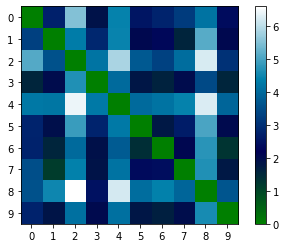

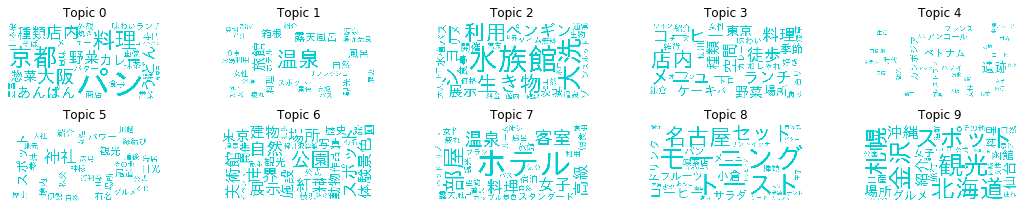

In [13]:
# KL divergence
plot_distance_matrix(lda_model)

# Visualize
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,3))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda_model.num_topics)):

    x = dict(lda_model.show_topic(t, 30))
    im = WordCloud(
        font_path=FONT,
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

plt.tight_layout()
plt.savefig("./visualize.png")

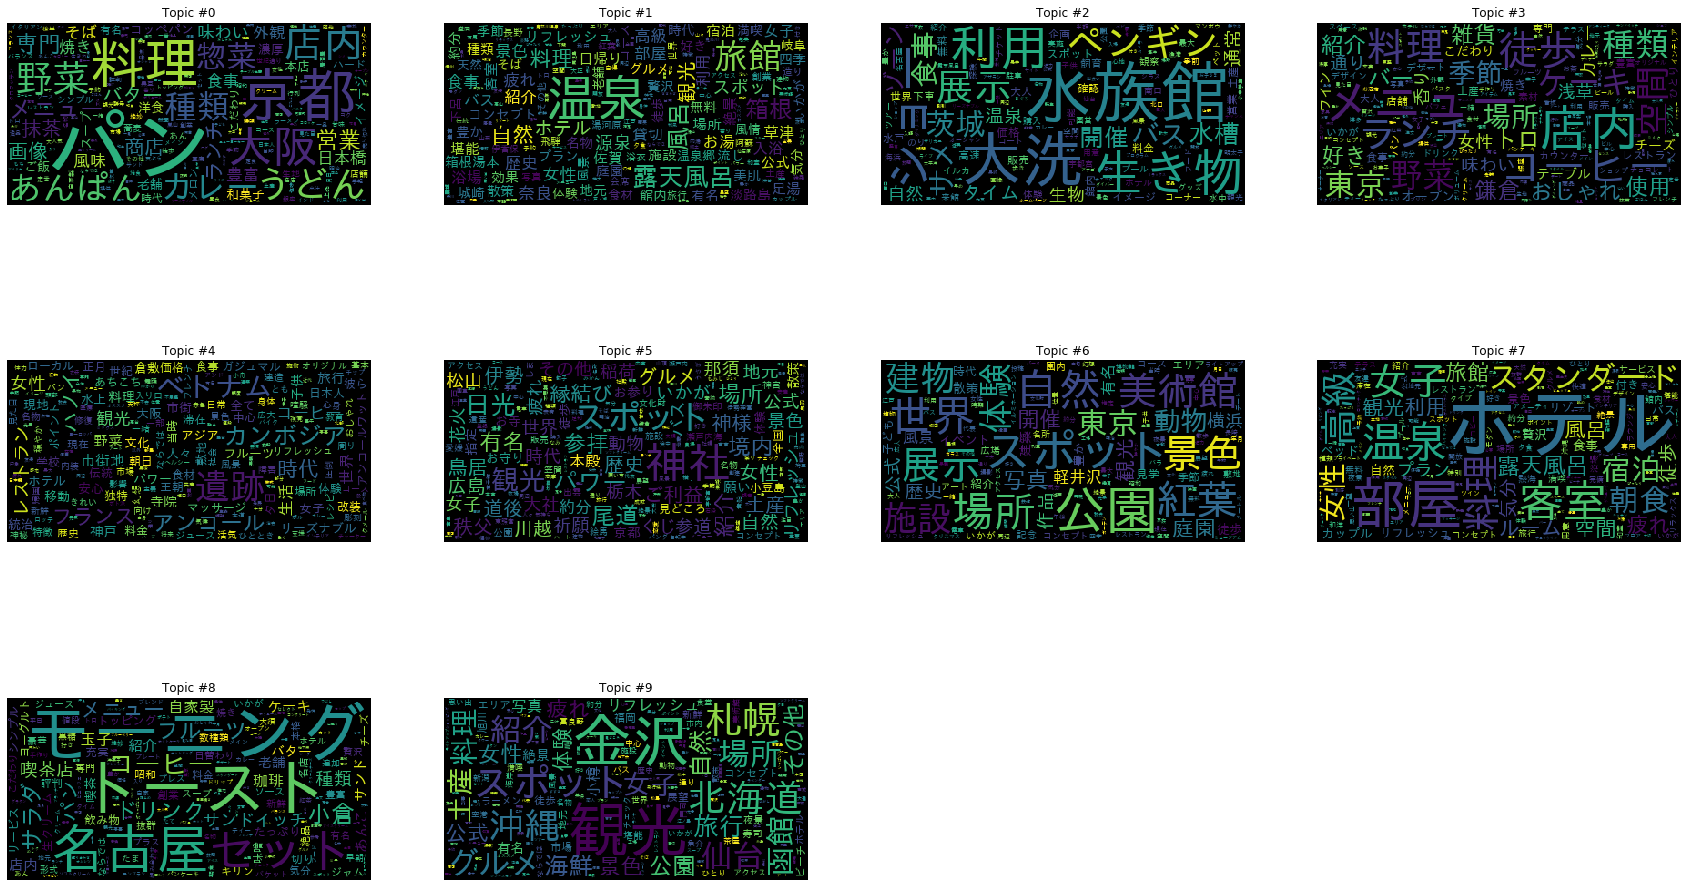

In [14]:
# WordCloud2
plt.figure(figsize=(30, 30))
for t in range(lda_model.num_topics):
    plt.subplot(5, 4, t+1)
    x = dict(lda_model.show_topic(t, 200))
    im = WordCloud(font_path=FONT).generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic #" + str(t))

plt.savefig("./visualize2.png")

In [0]:
# pyLDAvis
"""
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, './pyldavis_output.html')
"""

In [0]:
# Vis t-SNE
"""
vis_tsne = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='tsne', sort_topics=False)
vis_tsne

# save as html
pyLDAvis.save_html(vis_tsne, 'pyldavis_output_tsne.html')
"""

In [0]:
# Vis Metric MDS
"""
vis_mds = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds', sort_topics=False)
vis_mds

# save as html
pyLDAvis.save_html(vis_mds, 'pyldavis_output_mds.html')
"""

In [10]:
# output tags in topics
for x in lda_model.show_topics(-1, 20):
    print(x)
print(type(x))

(0, '0.015*"京都" + 0.015*"料理" + 0.008*"メニュー" + 0.007*"神社" + 0.006*"ランチ" + 0.006*"店内" + 0.005*"うどん" + 0.005*"野菜" + 0.004*"抹茶" + 0.004*"徒歩" + 0.004*"カレー" + 0.004*"画像" + 0.004*"味わい" + 0.004*"そば" + 0.004*"和菓子" + 0.004*"焼き" + 0.004*"種類" + 0.004*"季節" + 0.004*"その他" + 0.004*"本店"')
(1, '0.060*"温泉" + 0.019*"旅館" + 0.010*"露天風呂" + 0.010*"風呂" + 0.009*"箱根" + 0.007*"観光" + 0.007*"料理" + 0.007*"自然" + 0.006*"ホテル" + 0.005*"源泉" + 0.005*"女性" + 0.005*"部屋" + 0.004*"食事" + 0.004*"高級" + 0.004*"疲れ" + 0.004*"歴史" + 0.004*"紹介" + 0.004*"女子" + 0.004*"お湯" + 0.004*"利用"')
(2, '0.025*"水族館" + 0.021*"大洗" + 0.013*"生き物" + 0.012*"利用" + 0.012*"ショー" + 0.011*"ペンギン" + 0.011*"展示" + 0.010*"茨城" + 0.010*"サメ" + 0.009*"バス" + 0.009*"食事" + 0.008*"水槽" + 0.008*"開催" + 0.008*"ゾーン" + 0.007*"タイム" + 0.007*"温泉" + 0.007*"通常" + 0.006*"生物" + 0.006*"自然" + 0.006*"価格"')
(3, '0.011*"店内" + 0.010*"メニュー" + 0.009*"コーヒー" + 0.008*"徒歩" + 0.007*"空間" + 0.006*"ランチ" + 0.005*"種類" + 0.005*"料理" + 0.005*"東京" + 0.005*"ケーキ" + 0.005*"野菜" + 0.004*"場所" + 0.004*"おしゃれ" + 0.004

In [11]:
print("テキストの数：" + str(count))

テキストの数：6258


ストリーミング出力は最後の 5000 行に切り捨てられました。
(3, 0.49056193)
(3, 0.65369445)
(8, 0.99905944)
(0, 0.1)
(3, 0.38808015)
(2, 0.9990475)
(0, 0.74125844)
(3, 0.7773794)
(3, 0.5646801)
(0, 0.1)
(0, 0.5991785)
(3, 0.99676186)
(3, 0.5620935)
(3, 0.92328227)
(4, 0.998762)
(5, 0.9969798)
(3, 0.9676565)
(0, 0.8555035)
(8, 0.99905944)
(3, 0.48353252)
(2, 0.9990475)
(3, 0.7570283)
(0, 0.44365552)
(3, 0.61077005)
(3, 0.4121698)
(0, 0.1)
(6, 0.993616)
(3, 0.9667494)
(3, 0.77397764)
(6, 0.79662055)
(3, 0.9503397)
(3, 0.70492595)
(6, 0.88613623)
(6, 0.9151554)
(6, 0.92962617)
(3, 0.51012886)
(5, 0.9969798)
(3, 0.90444535)
(8, 0.99905944)
(6, 0.6100301)
(0, 0.86065936)
(2, 0.9990475)
(0, 0.1)
(3, 0.7695729)
(6, 0.9947055)
(3, 0.94587636)
(3, 0.7800552)
(0, 0.1)
(3, 0.6768069)
(3, 0.6360337)
(4, 0.998762)
(3, 0.8090991)
(3, 0.97729903)
(5, 0.9969798)
(1, 0.7601044)
(6, 0.9945447)
(3, 0.34845424)
(8, 0.99905944)
(2, 0.9990475)
(3, 0.8740794)
(9, 0.6393559)
(6, 0.45662627)
(3, 0.87903064)
(3, 0.913682)
(0, 0.70256495)


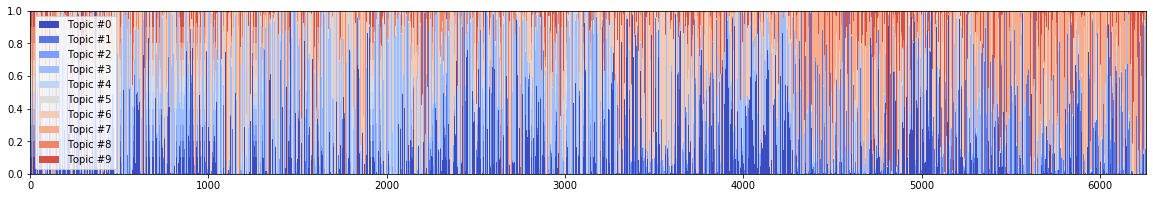

In [12]:
def show_document_topics(c, m, sample_size=10, width=1):
    import random
    import numpy as np
    import matplotlib.pylab as plt

    # make document/topics matrix
    d_topics = []
    t_documents = {}
    use_max_topic = []
    #samples = random.sample(range(len(c)), sample_size)
    for i in range(0, count):
        samples = [i]
        for s in samples:
            ts = m.__getitem__(corpus[s], -1)
            d_topics.append([v[1] for v in ts])
            max_topic = max(ts, key=lambda x: x[1])

            use_max_topic.append(max_topic[0])
            print(max_topic)
            
            if max_topic[0] not in t_documents:
                t_documents[max_topic[0]] = []
            t_documents[max_topic[0]] += [(s, max_topic[1])]

    print(samples)    
    print(type(samples))
    
    d_topics = np.array(d_topics)
    
    for t in t_documents:
        t_documents[t] = sorted(t_documents[t], key=lambda x: x[1], reverse=True)
    
    # draw cumulative bar chart
    fig = plt.figure(figsize=(20, 3))
    N, K = d_topics.shape
    indices = np.arange(N)
    height = np.zeros(N)
    bar = []
    for k in range(K):
        color = plt.cm.coolwarm(k / K, 1)
        p = plt.bar(indices, d_topics[:, k], width, bottom=None if k == 0 else height, color=color)
        height += d_topics[:, k]
        bar.append(p)
    
    
    plt.ylim((0, 1))
    plt.xlim((0, d_topics.shape[0]))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([b[0] for b in bar], topic_labels)
    plt.show(bar)
    
    return d_topics, t_documents, use_max_topic
    
document_topics, topic_documents, use_max_topic = show_document_topics(corpus, lda_model)

In [0]:
"""
#0~19トピックの頻出語を20個抽出する

for i in range(0, 20):
    exec("t_words" + str(i) + "= []")
    exec("t_words%d = lda_model.show_topic(i, 20)" % (i))

print(t_words2)
"""

In [0]:
"""
#無関係なワード削除
def format_text2(text):

    text=re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", text)
    #text=re.sub('投稿', "", text)
    #text=re.sub(r'\W', "", text)#英数字以外
    #text=re.sub(r'\A', "", text)#文字列の先頭
    #text=re.sub(r'\Z', "", text)#文字列の最後尾
    text=re.sub(r'[!-~]', "", text)#半角記号,数字,英字
    text=re.sub(r'[︰-＠]', "", text)#全角記号
    #text=re.sub('\n', " ", text)#改行文字

    return text
"""

In [0]:
"""
#文章から数字等を削除する

for i in range(0,20):
    exec("tt_words%d = ','.join(map(str, t_words%d))" % (i, i))
    exec("topic_words" + str(i) + "= []")
    exec("tw%d = format_text2(tt_words%d)" % (i, i))
    exec("topic_words%d = tw%d.split()" % (i, i))

print(topic_words0)
"""

In [0]:
"""
#各トピックの特徴語をカウントして特徴ベクトルを作る

for i in range(0, 20):
    exec("tmp += [dictionary.doc2bow(topic_words%d)]"% (i))

print(tmp)

dense = [list(matutils.corpus2dense([tmp[i]], num_terms=len(dictionary)).T[0]) for i in range(0, 20)]

print(dense)
"""

In [0]:
#コーパスに対して特徴ベクトルを作る

dense2 = [list(matutils.corpus2dense([corpus[i]], num_terms=len(dictionary)).T[0]) for i in range(0, count)]

print(dense2[0:4])
print(len(dense2))

"""
f = open('/content/drive/My Drive/ernie/travel_data/data/dense2.txt', 'wb')
pickle.dump(dense2, f)
f = open("/content/drive/My Drive/ernie/travel_data/data/dense2.txt","rb")
dense2 = pickle.load(f)
"""

In [0]:
#正解ラベルを作成する
print(use_max_topic)
print(len(use_max_topic))

"""
f = open('/content/drive/My Drive/ernie/travel_data/data/use_max_topic.txt', 'wb')
pickle.dump(use_max_topic, f)
f = open("/content/drive/My Drive/ernie/travel_data/data/use_max_topic.txt","rb")
use_max_topic = pickle.load(f)
"""

In [0]:
#機械学習

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# トピック0,,,,,,,20の20次元の特徴ベクトル
data_train =  dense2

# 正解のラベル
label_train = use_max_topic  # トピック1~19に分類

#ランダムフォレスト
estimator = RandomForestClassifier()
# ロジスティック回帰
clf_sk = LogisticRegression()

# 学習させる
#estimator.fit(data_train, label_train)
#clf_sk.fit(data_train, label_train)

In [0]:
# 予測
"""
label_predict = estimator.predict(data_train)
#print(label_predict)
print(estimator.score(data_train, label_train))
"""

In [20]:
from sklearn.model_selection import train_test_split

# 6割を学習用、 4割を試験用にする
data_train_s, data_test_s, label_train_s, label_test_s = train_test_split(data_train, label_train, test_size=0.3, random_state=0)

# 学習用に切り出したやつだけで学習
estimator.fit(data_train_s, label_train_s)
clf_sk.fit(data_train_s, label_train_s)

# 正解率
print(estimator.score(data_test_s, label_test_s))
print(clf_sk.score(data_test_s, label_test_s))

0.7326943556975506
0.8722044728434505
